In [2]:
### notebook for plotting ALL the maps!

In [3]:
# make necessary inputs
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors


from   astropy.io import fits
import astropy.units as u

#mpdaf used to manipulate the MUSE datacube
from mpdaf.obj import Cube, WCS, WaveCoord, Image
from mpdaf.drs import PixTable

import os
import optparse
import warnings
warnings.filterwarnings('ignore')
from matplotlib.tri import Triangulation, TriAnalyzer

from   mpl_toolkits.axes_grid1 import AxesGrid
from   matplotlib.ticker       import MultipleLocator, FuncFormatter

from plotbin.sauron_colormap import register_sauron_colormap
register_sauron_colormap()

# necessary to make matplotlib function well in the jupyter environment
%matplotlib inline

In [4]:
# set path and outdirectory
path = "data/gistTutorial/results/jeso-47509200-fullimg-030220_040920A/"
outdir = "Maps_Class_outdir"

In [5]:
# call the gandalf emission line file so you can see which numbers correspond to which lines
file = fits.open(path+"jeso-47509200-fullimg-030220_gandalf_BIN.fits")
file[1].data

FITS_rec([( 0.,   0., 'HeII', 3203.15, 'f', 'l',  1.  ,    0., 10., 'f', 2.56914136e-322),
          ( 1.,   1., '[NeV]', 3345.81, 'f', 'l',  1.  ,    0., 10., 'f', 2.56914136e-322),
          ( 2.,   2., '[NeV]', 3425.81, 'f', 'l',  1.  ,    0., 10., 'f', 2.56914136e-322),
          ( 3.,   3., '[OII]', 3726.03, 'f', 'l',  1.  ,    0., 10., 'f', 2.56914136e-322),
          ( 4.,   4., '[OII]', 3728.73, 'f', 'l',  1.  ,    0., 10., 'f', 2.56914136e-322),
          ( 5.,   5., '[NeIII]', 3868.69, 'f', 'l',  1.  ,    0., 10., 'f', 2.56914136e-322),
          ( 6.,   6., '[NeIII]', 3967.4 , 'f', 'l',  1.  ,    0., 10., 'f', 2.56914136e-322),
          ( 7.,  11., '[OIII]', 4363.15, 'f', 'l',  1.  ,    0., 10., 'f', 2.56914136e-322),
          ( 8.,  12., 'HeII', 4685.74, 'f', 'l',  1.  ,    0., 10., 'f', 2.56914136e-322),
          ( 9.,  13., '[ArIV]', 4711.3 , 'f', 'l',  1.  ,    0., 10., 't24', 2.56914136e-322),
          (10.,  14., '[ArIV]', 4740.1 , 'f', 'l',  1.  ,    0., 10., 't24

In [408]:
class Maps:
    # Class to make maps of GIST outputs
    # with customizable colorbars, the ability to take line ratios, and the ability to make side-by-side plots
    # of things that aren't side-by-side in the GIST outputs
    
    def __init__(self,outdir,LEVEL="BIN"):
    # Initialize the instance of this Class
    # from GIST sourcecode
    
    # read data in using the given outdir:
        self.runname  = outdir
        self.rootname = outdir.split('/')[-2].split('_')[0]
    
    # Read bintable
        self.table_hdu = fits.open(outdir+self.rootname+'_table.fits')
        self.X           = np.array( self.table_hdu[1].data.X )
        self.Y           = np.array( self.table_hdu[1].data.Y )
        self.FLUX        = np.array( self.table_hdu[1].data.FLUX )
        self.binNum_long = np.array( self.table_hdu[1].data.BIN_ID )
        self.ubins       = np.unique( np.abs(self.binNum_long) )
        self.pixelsize   = self.table_hdu[0].header['PIXSIZE']
        
    # Read in ppxf table:
        self.hdu = fits.open(outdir+self.rootname+'_ppxf.fits')
        self.result      = np.empty((len(self.ubins),4))
        self.result[:,0] = np.array( self.hdu[1].data.V     )
        self.result[:,1] = np.array( self.hdu[1].data.SIGMA )
        self.result[:,2] = np.array( self.hdu[1].data.H3    )
        self.result[:,3] = np.array( self.hdu[1].data.H4    )
        
        # Convert results to long version
        self.result_long  = np.zeros( (len(self.binNum_long), self.result.shape[1]) ); self.result_long[:,:] = np.nan
        for i in range( len(self.ubins) ):
            self.idx = np.where( self.ubins[i] == np.abs(self.binNum_long) )[0]
            self.result_long[self.idx,:]  = self.result[i,:]
        self.result = self.result_long
        self.result[:,0] = self.result[:,0] - np.nanmedian(self.result[:,0] )
        
    # read GANDALF result
        if LEVEL == 'SPAXEL':
            self.gandalf_emisetup = fits.open(outdir+self.rootname+'_gandalf_SPAXEL.fits')[1].data
            self.gandalf_raw      = fits.open(outdir+self.rootname+'_gandalf_SPAXEL.fits')[2].data
        elif LEVEL == 'BIN':
            self.gandalf_emisetup = fits.open(outdir+self.rootname+'_gandalf_BIN.fits')[1].data
            self.gandalf_raw      = fits.open(outdir+self.rootname+'_gandalf_BIN.fits')[2].data
        self.gandalf_Flux  = np.array( self.gandalf_raw.FLUX  )
        self.gandalf_Ampl  = np.array( self.gandalf_raw.AMPL  )
        self.gandalf_Vel   = np.array( self.gandalf_raw.V     )
        self.gandalf_Sigma = np.array( self.gandalf_raw.SIGMA )
        self.gandalf_AoN   = np.array( self.gandalf_raw.AON   )
    
        if LEVEL == 'BIN':
            self.gandalf_Flux_long = np.zeros( (len(self.binNum_long), self.gandalf_Flux.shape[1]) );  self.gandalf_Flux_long[:,:] = np.nan
            self.gandalf_Ampl_long = np.zeros( (len(self.binNum_long), self.gandalf_Ampl.shape[1]) );  self.gandalf_Ampl_long[:,:] = np.nan
            self.gandalf_Vel_long  = np.zeros( (len(self.binNum_long), self.gandalf_Vel.shape[1])  );  self.gandalf_Vel_long[:,:]  = np.nan
            self.gandalf_Sigma_long= np.zeros( (len(self.binNum_long), self.gandalf_Sigma.shape[1]));  self.gandalf_Sigma_long[:,:]= np.nan
            self.gandalf_AoN_long  = np.zeros( (len(self.binNum_long), self.gandalf_AoN.shape[1])  );  self.gandalf_AoN_long[:,:]  = np.nan

            for i in range( len(self.ubins) ):
                idx = np.where( self.ubins[i] == np.abs(self.binNum_long) )[0]
                self.gandalf_Flux_long[idx,:] = self.gandalf_Flux[i,:]
                self.gandalf_Ampl_long[idx,:] = self.gandalf_Ampl[i,:]
                self.gandalf_Vel_long[idx,:]  = self.gandalf_Vel[i,:]
                self.gandalf_Sigma_long[idx,:]= self.gandalf_Sigma[i,:]
                self.gandalf_AoN_long[idx,:]  = self.gandalf_AoN[i,:]
            
            self.gandalf_Flux    = self.gandalf_Flux_long
            self.gandalf_Ampl    = self.gandalf_Ampl_long
            self.gandalf_Vel     = self.gandalf_Vel_long
            self.gandalf_Sigma   = self.gandalf_Sigma_long
            self.gandalf_AoN     = self.gandalf_AoN_long
            
        self.gandalf_Flux  = np.array( self.gandalf_Flux  )
        self.gandalf_Ampl  = np.array( self.gandalf_Ampl  )
        self.gandalf_Vel   = np.array( self.gandalf_Vel   )
        self.gandalf_Sigma = np.array( self.gandalf_Sigma )
        self.gandalf_AoN   = np.array( self.gandalf_AoN   )
    
        self.X             = np.array( self.X             )
        self.Y             = np.array( self.Y             )
        
        
    def TicklabelFormatter(self,x,pos):
        # formats the tick label
        # how? I have no idea -- EW
        return ("${}$".format(int(x)))
        
        
    def setup_plot(self,usetex = False):
        # from GIST
        fontsize = 14
        dpi = 300
    
        plt.rc('font', family='serif')
        plt.rc('text', usetex=usetex)
    
        plt.rcParams['axes.labelsize'] = fontsize
        plt.rcParams['legend.fontsize'] = fontsize-3
        plt.rcParams['font.size'] = fontsize
    
        plt.rcParams['xtick.major.pad'] = '7'
        plt.rcParams['ytick.major.pad'] = '7'
    
        plt.rcParams['text.latex.preamble'] = [r'\boldmath']
    
    
    def velocity_set(self, vminmax, iterate, FLAG):
        # set vmin, vmax for colormap
        # inputs: custom: None, or a custom array; FLAG: "PPXF" or "GANDALF"
        # returns: vmin, vmax in km/s
        
        #default values
        if vminmax is None:
            if FLAG == "GANDALF":
                vmin_init = [-100, 60, 0, 0]
                vmax_init = [100, 160, 10, 1e5]
            elif FLAG == "PPXF":
                vmin_init = [-100, 60, -0.2, -0.2]
                vmax_init = [100, 160, 0.2, 0.2]
                
            vminmax=np.zeros((4,2))
            vminmax[:,0] = vmin_init
            vminmax[:,1] = vmax_init
            vmin = vminmax[iterate,0]
            vmax = vminmax[iterate,1]
        # customizable values
        else:    
            vmin = vminmax[iterate,0]
            vmax = vminmax[iterate,1]
            
        return vmin, vmax

        
    def ImageInPixels(self, val, vmin, vmax, grid, cmaplist, iterate, FLAG):
        # create image in pixels
        # inputs: val, vmin, vmax, grid, cmaplist, iterate, all from code
        #    FLAG: "PPXF" or "GANDALF"
        # outputs: image, a plot
              
        xmin = np.nanmin(self.X)-6;  xmax = np.nanmax(self.X)+6
        ymin = np.nanmin(self.Y)-6;  ymax = np.nanmax(self.Y)+6
        npixels_x = int( np.round( (xmax - xmin)/self.pixelsize ) + 1 )
        npixels_y = int( np.round( (ymax - ymin)/self.pixelsize ) + 1 )
        i = np.array( np.round( (self.X - xmin)/self.pixelsize ), dtype=np.int )
        j = np.array( np.round( (self.Y - ymin)/self.pixelsize ), dtype=np.int )
        image = np.full( (npixels_x, npixels_y), np.nan )
        image[i,j] = val
        
        if FLAG == "GANDALF":
            plottype = 0
        else: plottype = iterate
        #plottype = iterate
        image = grid[plottype].imshow(np.rot90(image), cmap=cmaplist[iterate], interpolation=None, vmin=vmin, vmax=vmax, \
                extent=[xmin-self.pixelsize/2, xmax+self.pixelsize/2, ymin-self.pixelsize/2, ymax+self.pixelsize/2])
        
        return image
    
                    
    def plot_PPXF(self, outdir, vminmax=None, contour_offset_saved=0.20, contour=False):
        # Create/Set output directory
        # EW - we don't need this rn for our purposes
        # can uncomment later if needed
       # if os.path.isdir(outdir+'maps/') == False:
       #     os.mkdir(outdir+'maps/')
       # outdir = outdir+'maps/'
        
        # set list of colormaps
        cmaplist = ['RdYlBu_r', 'RdYlBu_r', 'RdYlBu', 'RdYlBu_r']
        # Setup main figure
        self.setup_plot()
        fig = plt.figure(figsize=(16,16))
        grid = AxesGrid(fig, 111, nrows_ncols=(2, 2),axes_pad = 1.5, share_all=True,\
                    label_mode="all", cbar_location="right", cbar_mode="each", cbar_size='4%', cbar_pad="2%")
    
        for iterate in range(0,4):
            # Prepare main plot
            val = self.result[:,iterate]
            vmin, vmax = self.velocity_set(vminmax, iterate, FLAG="PPXF")
            
            #invert x-axis
            #grid[iterate].invert_xaxis()
        
            image = self.ImageInPixels(val, vmin, vmax, grid, cmaplist, iterate,FLAG="PPXF")
            # set colorbar ticks
            grid.cbar_axes[iterate].colorbar(image)
            
        if contour==True:
                Y_Triangulation = Triangulation(self.X-self.pixelsize/2, self.Y-self.pixelsize/2)                      # Create a mesh from a Delaunay triangulation
                XY_Triangulation.set_mask( TriAnalyzer(XY_Triangulation).get_flat_tri_mask(0.01) )  # Remove bad triangles at the border of the field-of-view
                levels = np.arange( np.min(np.log10( self.FLUX )) + contour_offset, np.max(np.log10( self.FLUX )), 0.2 )
                grid[iterate].tricontour(XY_Triangulation, np.log10(self.FLUX), levels=levels, linewidths=1, colors='k')
        else:
            print("Contours will not be plotted")
            
        # Set tick labels from colorbar
        for cax in grid.cbar_axes:
            cax.tick_params(labelsize=12)
        
        # Set V, SIGMA, H3, H4 labels
        grid[0].text(0.02,  0.98, r'$V_{stellar} (km/s) $',      horizontalalignment='left',  verticalalignment='top', transform = grid[0].transAxes, fontsize=16)
        grid[1].text(0.02,  0.98 , r'$\sigma_{stellar} (km/s)$', horizontalalignment='left',  verticalalignment='top', transform = grid[1].transAxes, fontsize=16)
        grid[2].text(0.02,  0.98 , r'h3',                        horizontalalignment='left',  verticalalignment='top', transform = grid[2].transAxes, fontsize=16)
        grid[3].text(0.02,  0.98 , r'h4',                        horizontalalignment='left',  verticalalignment='top', transform = grid[3].transAxes, fontsize=16)
        # Set xlabel and ylabel
        grid[0].set_ylabel(r'$\Delta \delta$ [arcsec]')
        grid[2].set_ylabel(r'$\Delta \delta$ [arcsec]')
        grid[0].set_xlabel(r'$\Delta \delta$ [arcsec]')
        grid[1].set_xlabel(r'$\Delta \delta$ [arcsec]')
        grid[2].set_xlabel(r'$\Delta \alpha$ [arcsec]')
        grid[3].set_xlabel(r'$\Delta \alpha$ [arcsec]')
          
        # Invert x-axis
        # grid[0].invert_xaxis()
        
        # adjust white space
        fig.subplots_adjust(wspace=0.5, hspace=0.05)
        
        plt.show()
        
        
    def Gandalf_setup_plot(self, wings):
        self.setup_plot(usetex=False)
        
        if wings == "yes": fig = plt.figure(figsize=(21,7)); grid = AxesGrid(fig,111, nrows_ncols=(1, 3), axes_pad=0.0,\
                                    share_all=True, label_mode="L", cbar_location="right", cbar_mode="single", cbar_size='6%')
        else: fig = plt.figure(figsize=(7,7)); grid = AxesGrid(fig, 111, nrows_ncols=(1, 1), axes_pad=0.0,\
                        share_all=True, label_mode="L", cbar_location="right", cbar_mode="single", cbar_size='6%')
        contour_offset = 0.20
        return grid
        
        
    def Gandalf_plot_line(self,outdir,operation, line_idx, vminmax, AoNThreshold, LEVEL, iterate, lineIdentifier, contour_offset_saved,title):
        if operation == 1: print("operation selected: SUBTRACTION")
        elif operation == 2: print("operation selected: RATIO")
        elif operation == 0: print("operation selected: NONE")
        else: print("invalid operation input. please input 0, 1 or 2."); exit(1)
    # get lists
        labellist = ['V', 'S', 'F', 'A']
        cmaplist = ["RdYlBu_r", "RdYlBu_r", "YlGn", "YlGn"]
        title = [title] 
    # set line indices
        if type(line_idx) == int:
            line1 = np.array([line_idx])
            line2 = 0
            wings = "no"
            FLAG = "GANDALF"
            iterate_for_img = np.array([iterate])
            cmaplist = ["RdYlBu_r", "RdYlBu_r", "YlGn", "YlGn"]
        else:
            # plot multiple plots
            if len(line_idx) >= 3:
                if iterate >= 2: cmaplist = ["YlGn", "YlGn", "YlGn"]
                else:cmaplist = ["RdYlBu_r", "RdYlBu_r", "RdYlBu_r"]

                iterate_for_img = np.array([0,1,2])
                wings = "yes"
                line1 = np.zeros(3)
                i = 0
                title = ["%s Blue Wing"%title, "%s Core" %title, "%s Red Wing"%title]
                for i in range(3):
                    line1[i] = line_idx[i]
                if operation >= 1:
                    line2 = np.zeros(3)
                    for j in range(3,6):
                        line2[j-3] = line_idx[j]
                FLAG = None
            # plot one plot, with operation
            else:
                wings = "no"
                print(wings)
                line1 = np.array([line_idx[0]])
                line2 = np.array([line_idx[1]])
                FLAG = "GANDALF"
                iterate_for_img = np.array([iterate])
                cmaplist = ["RdYlBu_r", "RdYlBu_r", "YlGn", "YlGn"]
       
        # Setup main figure
        grid = self.Gandalf_setup_plot(wings)
        
        # set vmin, vmax for colorbar
        vmin, vmax = self.velocity_set(vminmax, iterate, FLAG)
        print("vmin, vmax set:", vmin, vmax)
        i = 0
        for i in range(len(line1)):
            line = int(line1[i])
            print(line)
            if operation >= 1:
                linetwo = int(line2[i])
        # Velocity
            if iterate == 0:
                # set if there is an operation or not
                if operation == 1: val = np.subtract(self.gandalf_Vel[:,line],self.gandalf_Vel[:,linetwo])
                elif operation == 2: val = np.divide(self.gandalf_Vel[:,line],self.gandalf_Vel[:,linetwo]);
                elif operation == 0: val = self.gandalf_Vel[:,line]
        # Dispersion
            if iterate == 1: 
                if operation == 0: val = self.gandalf_Sigma[:,line]
                elif operation == 1: val = np.subtract(self.gandalf_Sigma[:,line],self.gandalf_Sigma[:, linetwo])
                elif operation == 2: val = np.divide(self.gandalf_Sigma[:,line1],self.gandalf_Sigma[:, linetwo])
        # Flux
            if iterate == 2:
                if operation == 1: val = np.subtract(( self.gandalf_Flux[:,line] ),( self.gandalf_Flux[:,linetwo] ))
                elif operation == 2: val = np.divide(( self.gandalf_Flux[:,line] ),( self.gandalf_Flux[:,linetwo] )); val = np.log10(np.abs(val))
                elif operation == 0: val = ( self.gandalf_Flux[:,line] ); val = np.log10(np.abs(val))
        # Amplitude
            if iterate == 3: 
                if operation == 1: val = np.subtract( self.gandalf_Ampl[:,line],( self.gandalf_Ampl[:,linetwo] ) )
                elif operation == 2: val = np.divide( self.gandalf_Ampl[:,line],( self.gandalf_Ampl[:,linetwo] ) ); val = np.log10(np.abs(val))
                elif operation == 0: val = self.gandalf_Ampl[:,line]
        # check that the results are real numbers
            
            if len( np.where( np.isnan(val) == True )[0] ) == len(val):
                print("whoops! All NaNs!")
                return(None)
            
        # Create image in pixel
            image = self.ImageInPixels(val, vmin, vmax, grid, cmaplist, iterate_for_img[i], FLAG) 
            grid.cbar_axes[i].colorbar(image)
            # Set labels
            # title
            grid[i].text(0.985, 0.975, title[i] , horizontalalignment='right', verticalalignment='top', transform = grid[i].transAxes, fontsize=16) 
             # Set xlabel and ylabel
            grid[i].set_xlabel(r'$\Delta \alpha$ [arcsec]'); grid[i].set_ylabel(r'$\Delta \delta$ [arcsec]')
        # plot type
        if iterate == 0: 
            grid[0].text(0.02, 0.98, r'$V$ $ (km/s) $',  horizontalalignment='left', verticalalignment='top', transform = grid[0].transAxes, fontsize=16)
        elif iterate == 1:
            grid[0].text(0.02, 0.98, r'$\sigma [km/s]$', horizontalalignment='left', verticalalignment='top', transform = grid[0].transAxes, fontsize=16)
        elif iterate == 2:
            grid[0].text(0.02, 0.98, r' Flux ',          horizontalalignment='left', verticalalignment='top', transform = grid[0].transAxes, fontsize=16)
        elif iterate == 3:
            grid[0].text(0.02, 0.98, r' Ampl ',          horizontalalignment='left', verticalalignment='top', transform = grid[0].transAxes, fontsize=16)
            
        # Fix minus sign in ticklabels
        grid[0].xaxis.set_major_formatter(FuncFormatter(self.TicklabelFormatter))
        grid[0].yaxis.set_major_formatter(FuncFormatter(self.TicklabelFormatter))
        # Set tick frequency and parameters
        grid[0].xaxis.set_major_locator(MultipleLocator(10));  grid[i].yaxis.set_major_locator(MultipleLocator(10))  # Major tick every 10 units
        grid[0].xaxis.set_minor_locator(MultipleLocator(1));   grid[i].yaxis.set_minor_locator(MultipleLocator(1))   # Minor tick every 1 units
        grid[0].tick_params(direction="in", which='both', bottom=True, top=True, left=True, right=True)              # Ticks inside of plot
        plt.show()
        
        # Save plot
        #plt.savefig(outdir+self.rootname+'_gandalf-'+lineIdentifier[0]+lineIdentifier[1]+'_'+labellist[iterate]+'_'+LEVEL+'.pdf', bbox_inches='tight', pad_inches=0.3)
                                
    def Gandalf_plot_maps(self, outdir, operation, line_idx, plottype,vminmax=None, AoNThreshold=4, LEVEL="BIN", title="Title"):
        # Get list of emission lines
        linelist = []
        for i in range( len(self.gandalf_emisetup.name) ):
            linelist.append( [self.gandalf_emisetup.name[i].decode('utf-8'), str(self.gandalf_emisetup._lambda[i])] )
        print("linelist grabbed")
        # Apply AoN threshold to GANDALF
        for i in range(0, self.gandalf_AoN.shape[1]):
           
            if AoNThreshold < 0: idx_AoNThreshold = np.where( self.gandalf_AoN[:,i] > AoNThreshold )[0]
            else: idx_AoNThreshold = np.where( self.gandalf_AoN[:,i] < AoNThreshold )[0]
            
            self.gandalf_Flux[idx_AoNThreshold,i]  = np.nan
            self.gandalf_Ampl[idx_AoNThreshold,i]  = np.nan
            self.gandalf_Vel[idx_AoNThreshold,i]   = np.nan
            self.gandalf_Sigma[idx_AoNThreshold,i] = np.nan
            self.gandalf_AoN[idx_AoNThreshold,i]   = np.nan
        print("AoN threshold determined:", AoNThreshold)
    
        self.gandalf_Flux[ np.where(self.gandalf_Flux ==-1)[0] ] = np.nan
        self.gandalf_Ampl[ np.where(self.gandalf_Ampl ==-1)[0] ] = np.nan
        self.gandalf_Vel[  np.where(self.gandalf_Vel  ==-1)[0] ] = np.nan
        self.gandalf_Sigma[np.where(self.gandalf_Sigma==-1)[0] ] = np.nan
       
        self.gandalf_Vel   = self.gandalf_Vel - np.nanmedian( self.gandalf_Vel )
        
        # Create/Set output directory
        if os.path.isdir(outdir+'maps/') == False:
            os.mkdir(outdir+'maps/')
        outdir = outdir+'maps/'
        
        # set plottype
        if type(line_idx) == int:
            lineIdentifier = linelist[int(line_idx)]
        else: lineIdentifier = linelist[int(line_idx[0])]
        if plottype == 'V': iterate = 0
        elif plottype == 'S': iterate = 1
        elif plottype == 'F': iterate = 2
        elif plottype == 'A': iterate = 3
        else: print("No plottype set. Exit!"); exit(1)
        contour_offset_saved=.2
            
        self.Gandalf_plot_line(outdir,operation, line_idx, vminmax, AoNThreshold, LEVEL,iterate, lineIdentifier, contour_offset_saved,title)
        
        
    def Gandalf_gistPlot(self,outdir, operation, line, plottype="V" , vminmax=None, AoN_Threshold=4, level="BIN", title="Title"):
        print("line", line,"selected")
        
        self.Gandalf_plot_maps(outdir,operation,line_idx=line, plottype=plottype, vminmax=vminmax, AoNThreshold=AoN_Threshold, LEVEL=level,title=title)
    
        plt.show()
        
    # add function to subtract gas from stellar velocity
    def StarGasDifference(self, outdir, line,vminmax, plottype, AoNThreshold, LEVEL, title, AoNToggle = True):
        # inputs:
        #  outdir, line, plottype, vminmax, AoNThreshold, LEVEL, title, described at top
        #       AoNToggle: decides if an AoNThreshold will be applied to the map
        
        # Get list of emission lines
        linelist = []
        for i in range( len(self.gandalf_emisetup.name) ):
            linelist.append( [self.gandalf_emisetup.name[i].decode('utf-8'), str(self.gandalf_emisetup._lambda[i])] )

        print("linelist grabbed")
        FLAG = "GANDALF"
      
        # call the gas information
        gas_vel = self.gandalf_Vel[:,line]
        gas_sigma = self.gandalf_Sigma[:,line]
        gas_flux = self.gandalf_Flux[:,line]
        gas_ampl = self.gandalf_Ampl[:,line]
        
        # call the stellar information
        star_vel = self.result[:,0]
        star_sigma = self.result[:,1]
        star_flux = self.result[:,2]
        star_ampl = self.result[:,3]
        
        # subtract gas from stars
        starGasDiff_Vel = np.subtract(gas_vel, star_vel)
        starGasDiff_Sigma = np.subtract(gas_sigma, star_sigma)
        starGasDiff_Flux = np.subtract(gas_flux, star_flux)
        starGasDiff_Ampl = np.subtract(gas_ampl, star_ampl)

        # Apply AoN threshold to GANDALF
        if AoNToggle == True:
            
            if AoNThreshold < 0: idx_AoNThreshold = np.where( self.gandalf_AoN[:,line] > AoNThreshold )[0]
            else: idx_AoNThreshold = np.where( self.gandalf_AoN[:,line] < AoNThreshold )[0]
    
            starGasDiff_Flux[idx_AoNThreshold]  = np.nan
            starGasDiff_Ampl[idx_AoNThreshold]  = np.nan
            starGasDiff_Vel[idx_AoNThreshold]   = np.nan
            starGasDiff_Sigma[idx_AoNThreshold] = np.nan
            self.gandalf_AoN[idx_AoNThreshold]   = np.nan
            
            # still using the GANDALF values to decide where not to plot
            starGasDiff_Flux[ np.where(self.gandalf_Flux ==-1)[0] ] = np.nan
            starGasDiff_Ampl[ np.where(self.gandalf_Ampl ==-1)[0] ] = np.nan
            starGasDiff_Vel[  np.where(self.gandalf_Vel  ==-1)[0] ] = np.nan
            starGasDiff_Sigma[np.where(self.gandalf_Sigma==-1)[0] ] = np.nan
       
        starGasDiff_Vel   = starGasDiff_Vel - np.nanmedian( starGasDiff_Vel )
        
        # set plottype
        if plottype == 'V': iterate = 0; val = starGasDiff_Vel
        elif plottype == 'S': iterate = 1; val = starGasDiff_Sigma
        elif plottype == 'F': iterate = 2; val = starGasDiff_Flux
        elif plottype == 'A': iterate = 3; val = starGasDiff_Ampl
         
        # check that we don't have arrays of entirely nans
        if len( np.where( np.isnan(val) == True )[0] ) == len(val):
            print("whoops! All NaNs!")
            return(None)
        
        # set vmin, vmax for colormap
        vmin, vmax = self.velocity_set(vminmax, iterate, FLAG)
        
        # set up for plots
        labellist = ['V', 'S', 'F', 'A']
        cmaplist = ["RdYlBu_r", "RdYlBu_r", "Blues", "Blues"]
        
        # Setup main figure
        grid = self.Gandalf_setup_plot()
        
        image = self.ImageInPixels(val, vmin, vmax, grid, cmaplist, iterate, FLAG)
        
        if iterate == 2: grid.cbar_axes[0].colorbar(image, norm=colors.LogNorm())
        else: grid.cbar_axes[0].colorbar(image)
        # Set labels
             # title
        grid[0].text(0.985, 0.975, title , horizontalalignment='right', verticalalignment='top', transform = grid[0].transAxes, fontsize=16)    
             # plot type
        if iterate == 0: 
            grid[0].text(0.02, 0.98, r'$V$ $ (km/s) $',  horizontalalignment='left', verticalalignment='top', transform = grid[0].transAxes, fontsize=16)
        elif iterate == 1:
            grid[0].text(0.02, 0.98, r'$\sigma [km/s]$', horizontalalignment='left', verticalalignment='top', transform = grid[0].transAxes, fontsize=16)
        elif iterate == 2:
            grid[0].text(0.02, 0.98, r' Flux ',          horizontalalignment='left', verticalalignment='top', transform = grid[0].transAxes, fontsize=16)
        elif iterate == 3:
            grid[0].text(0.02, 0.98, r' Ampl ',          horizontalalignment='left', verticalalignment='top', transform = grid[0].transAxes, fontsize=16)
       
        # Set xlabel and ylabel
        grid[0].set_xlabel(r'$\Delta \alpha$ [arcsec]')
        grid[0].set_ylabel(r'$\Delta \delta$ [arcsec]')
        
        # Fix minus sign in ticklabels
        grid[0].xaxis.set_major_formatter(FuncFormatter(self.TicklabelFormatter))
        grid[0].yaxis.set_major_formatter(FuncFormatter(self.TicklabelFormatter))

        # Set tick frequency and parameters
        grid[0].xaxis.set_major_locator(MultipleLocator(10));  grid[0].yaxis.set_major_locator(MultipleLocator(10))  # Major tick every 10 units
        grid[0].xaxis.set_minor_locator(MultipleLocator(1));   grid[0].yaxis.set_minor_locator(MultipleLocator(1))   # Minor tick every 1 units
        grid[0].tick_params(direction="in", which='both', bottom=True, top=True, left=True, right=True)              # Ticks inside of plot
        # Save plot
        #plt.savefig(outdir+self.rootname+'_gandalf-'+lineIdentifier[0]+lineIdentifier[1]+'_'+labellist[iterate]+'_'+LEVEL+'.pdf', bbox_inches='tight', pad_inches=0.3)
        plt.show()

In [410]:
# create instance of the class
test = Maps(path)

line [33 18 39] selected
linelist grabbed
AoN threshold determined: 4
operation selected: NONE
vmin, vmax set: -250.0 250.0


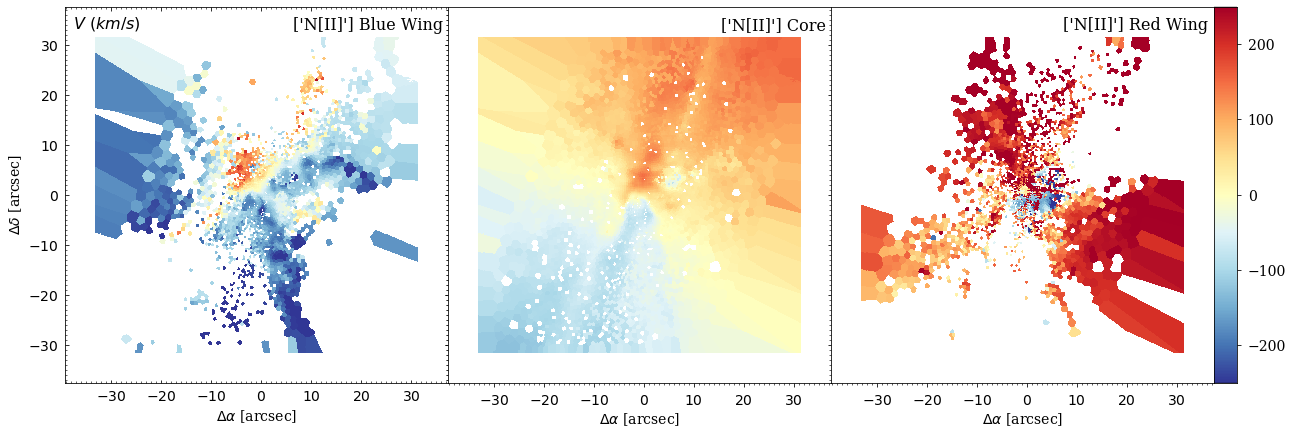

line [33 18 39] selected
linelist grabbed
AoN threshold determined: 4
operation selected: NONE
vmin, vmax set: 0.0 100.0


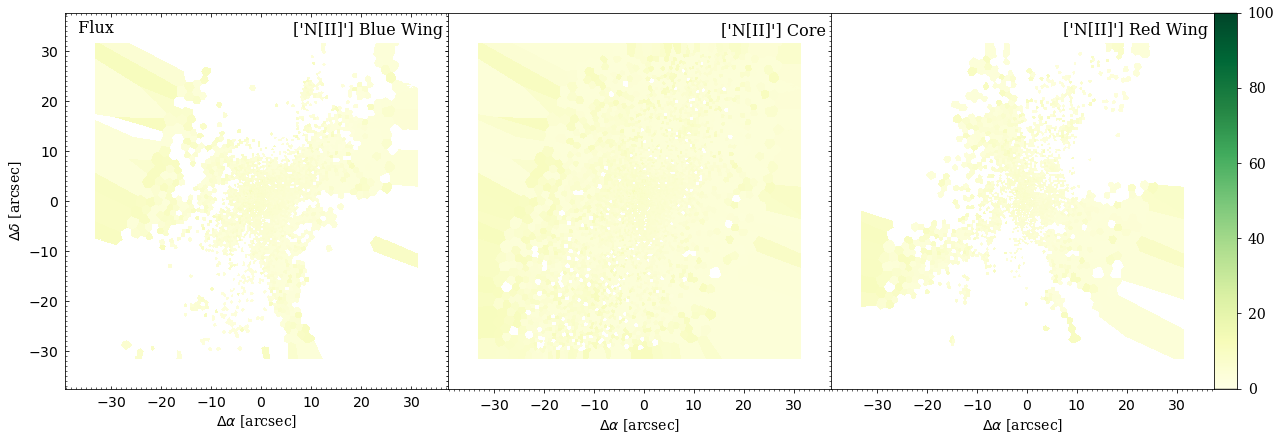

In [405]:
vminmax_gandalf=np.zeros((4,2))
vmin_init_gandalf = [-250, 50, 0, -150]   #min value for colorbar for: V, sigma, h3, h4
vmax_init_gandalf = [250, 150, 100, 150]  #max value for colorbar for: V, sigma, h3, h4
vminmax_gandalf[:,0] = vmin_init_gandalf
vminmax_gandalf[:,1] = vmax_init_gandalf
line = np.array([33,18,39])
test.Gandalf_gistPlot(path,0,line,plottype="V", vminmax=vminmax_gandalf, title="N[II]")
test.Gandalf_gistPlot(path,0,line,plottype="F", vminmax=vminmax_gandalf, title="N[II]")


line [33 18 39 32 17 38] selected
linelist grabbed
AoN threshold determined: 4
operation selected: RATIO
vmin, vmax set: 0.0 0.5


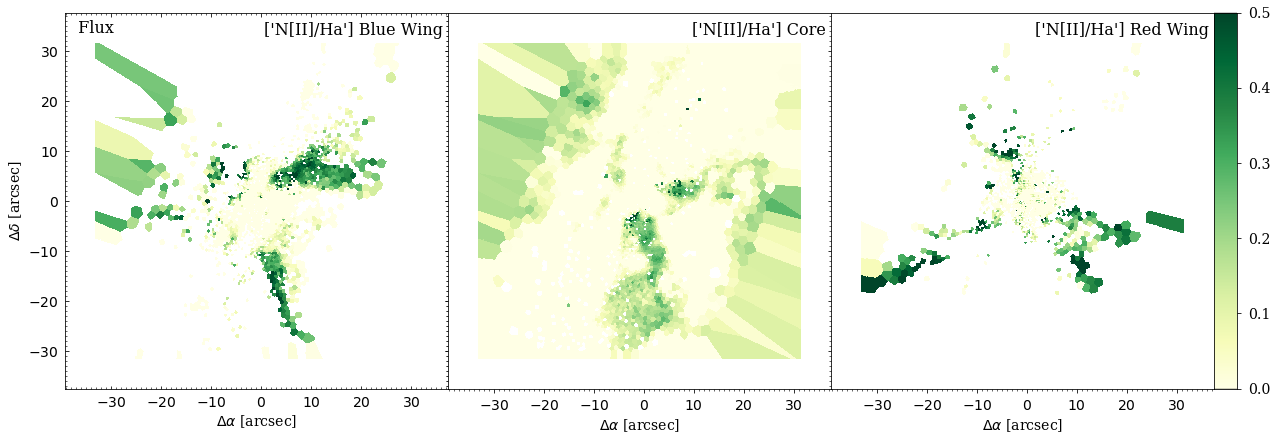

line [12 11] selected
linelist grabbed
AoN threshold determined: 4
operation selected: RATIO
no
vmin, vmax set: 0.0 0.5


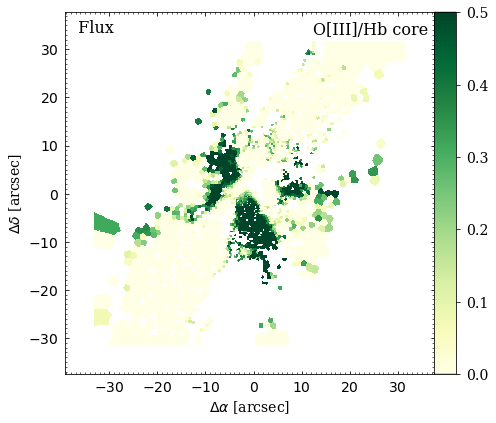

line [27 26] selected
linelist grabbed
AoN threshold determined: 4
operation selected: RATIO
no
vmin, vmax set: 0.0 0.5


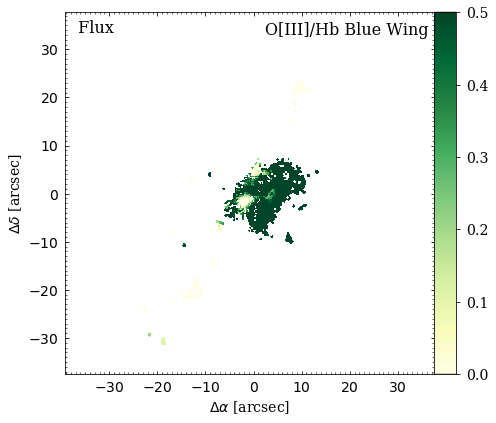

In [406]:
vminmax_gandalf=np.zeros((4,2))
vmin_init_gandalf = [-100, 50, 0, -150]   #min value for colorbar for: V, sigma, h3, h4
vmax_init_gandalf = [100, 150, .5, 150]  #max value for colorbar for: V, sigma, h3, h4
vminmax_gandalf[:,0] = vmin_init_gandalf
vminmax_gandalf[:,1] = vmax_init_gandalf
line = np.array([33,18,39,32,17,38])

test.Gandalf_gistPlot(path,2,line,plottype="F", vminmax=vminmax_gandalf, title="N[II]/Ha")
test.Gandalf_gistPlot(path,2,np.array([12,11]),plottype="F",vminmax=vminmax_gandalf,title="O[III]/Hb core")
test.Gandalf_gistPlot(path,2,np.array([27,26]),plottype="F",vminmax=vminmax_gandalf,title="O[III]/Hb Blue Wing")

line [27 12 37] selected
linelist grabbed
AoN threshold determined: 4
operation selected: NONE
vmin, vmax set: -250.0 250.0


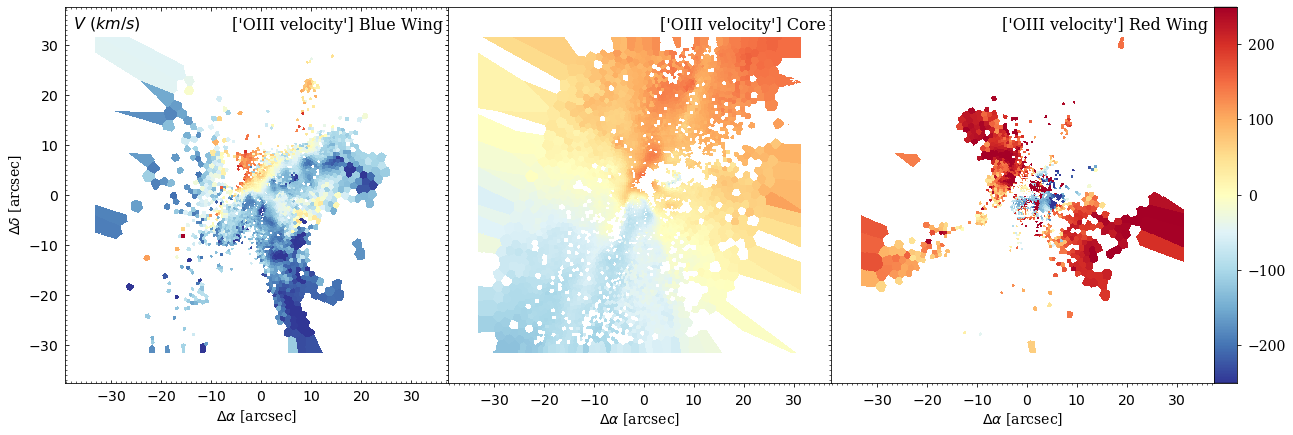

line [33 18 39] selected
linelist grabbed
AoN threshold determined: 4
operation selected: NONE
vmin, vmax set: -250.0 250.0


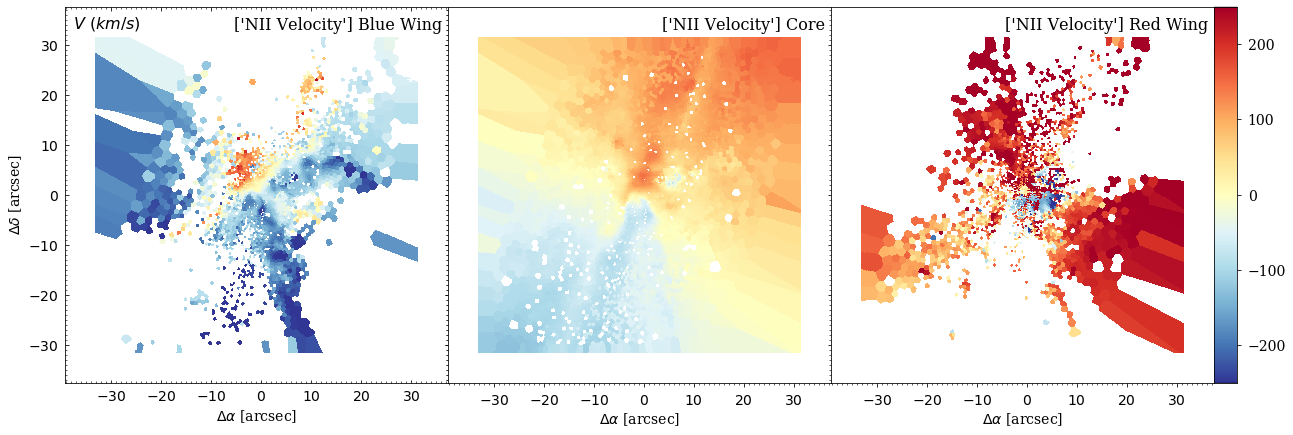

In [395]:
vminmax_gandalf=np.zeros((4,2))
vmin_init_gandalf = [-250, 0, 0, 0]   
vmax_init_gandalf = [250, 150, 10000, 1000]#max value for colorbar for: V, sigma, flux, amplitude
vminmax_gandalf[:,0] = vmin_init_gandalf
vminmax_gandalf[:,1] = vmax_init_gandalf
# testing each plot type
test.Gandalf_gistPlot(outdir,0,np.array([27,12,37]),"V",vminmax=vminmax_gandalf, title="OIII velocity")
test.Gandalf_gistPlot(outdir,0,np.array([33,18,39]),"V",vminmax=vminmax_gandalf, title="NII Velocity")

line 12 selected
linelist grabbed
AoN threshold determined: 4
operation selected: NONE
[12]
vmin, vmax set: -150.0 150.0


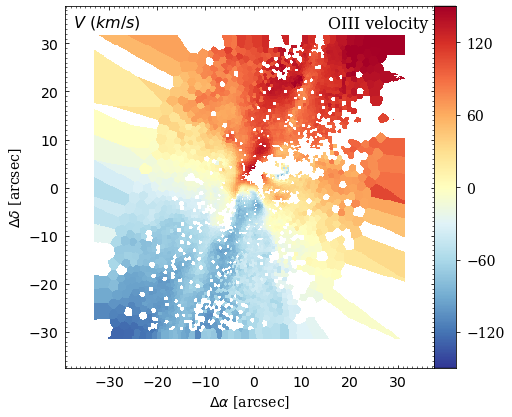

line 12 selected
linelist grabbed
AoN threshold determined: 4
operation selected: NONE
[12]
vmin, vmax set: 0.0 150.0


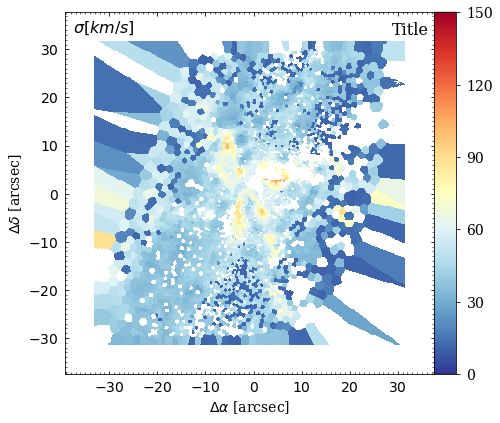

line 12 selected
linelist grabbed
AoN threshold determined: 4
operation selected: NONE
[12]
vmin, vmax set: 0.0 10000.0


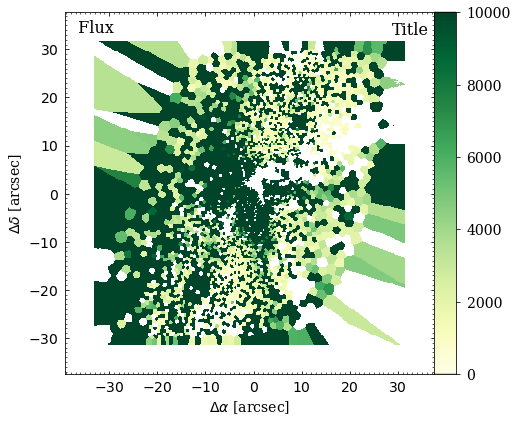

line 12 selected
linelist grabbed
AoN threshold determined: 4
operation selected: NONE
[12]
vmin, vmax set: 0.0 1000.0


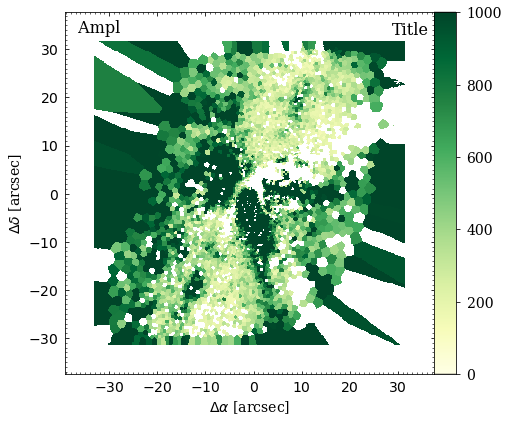

In [280]:
# gandalf example
vminmax_gandalf=np.zeros((4,2))
vmin_init_gandalf = [-150, 0, 0, 0]   
vmax_init_gandalf = [150, 150, 10000, 1000]#max value for colorbar for: V, sigma, flux, amplitude
vminmax_gandalf[:,0] = vmin_init_gandalf
vminmax_gandalf[:,1] = vmax_init_gandalf
# testing each plot type
test.Gandalf_gistPlot(outdir,0,12,"V",vminmax=vminmax_gandalf, title="OIII velocity")
test.Gandalf_gistPlot(outdir,0,12,"S",vminmax=vminmax_gandalf)
test.Gandalf_gistPlot(outdir,0,12,"F",vminmax=vminmax_gandalf)
test.Gandalf_gistPlot(outdir,0,12,"A",vminmax=vminmax_gandalf)


line [12 11] selected
linelist grabbed
AoN threshold determined: 4
operation selected: RATIO
no
[12]
vmin, vmax set: 0.0 10.0


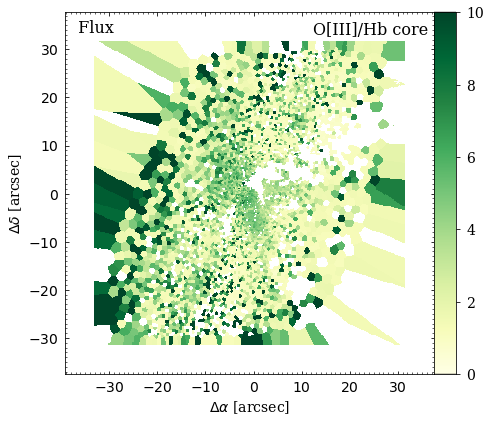

line [18, 17] selected
linelist grabbed
AoN threshold determined: 4
operation selected: RATIO
no
[18]
vmin, vmax set: 0.0 10.0


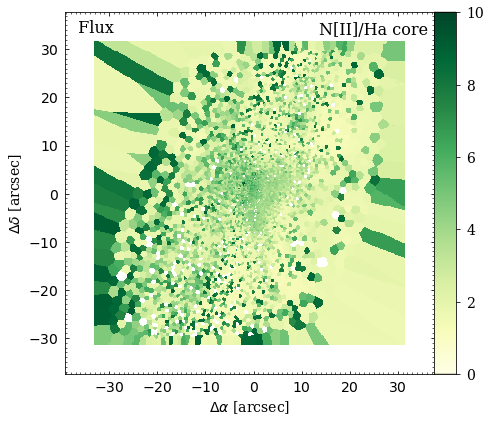

In [140]:
# gandalf ratio example
vmin_init_gandalf = [-100, 50, 0, -150]   #min value for colorbar for: V, sigma, h3, h4
vmax_init_gandalf = [100, 150, 10, 150]  #max value for colorbar for: V, sigma, h3, h4
vminmax_gandalf[:,0] = vmin_init_gandalf
vminmax_gandalf[:,1] = vmax_init_gandalf
line = np.array([12,11])

test.Gandalf_gistPlot(path,2,line,plottype="F", vminmax=vminmax_gandalf, title="O[III]/Hb core")

test.Gandalf_gistPlot(path,2,[18,17],plottype="F", vminmax=vminmax_gandalf, title="N[II]/Ha core")

Contours will not be plotted


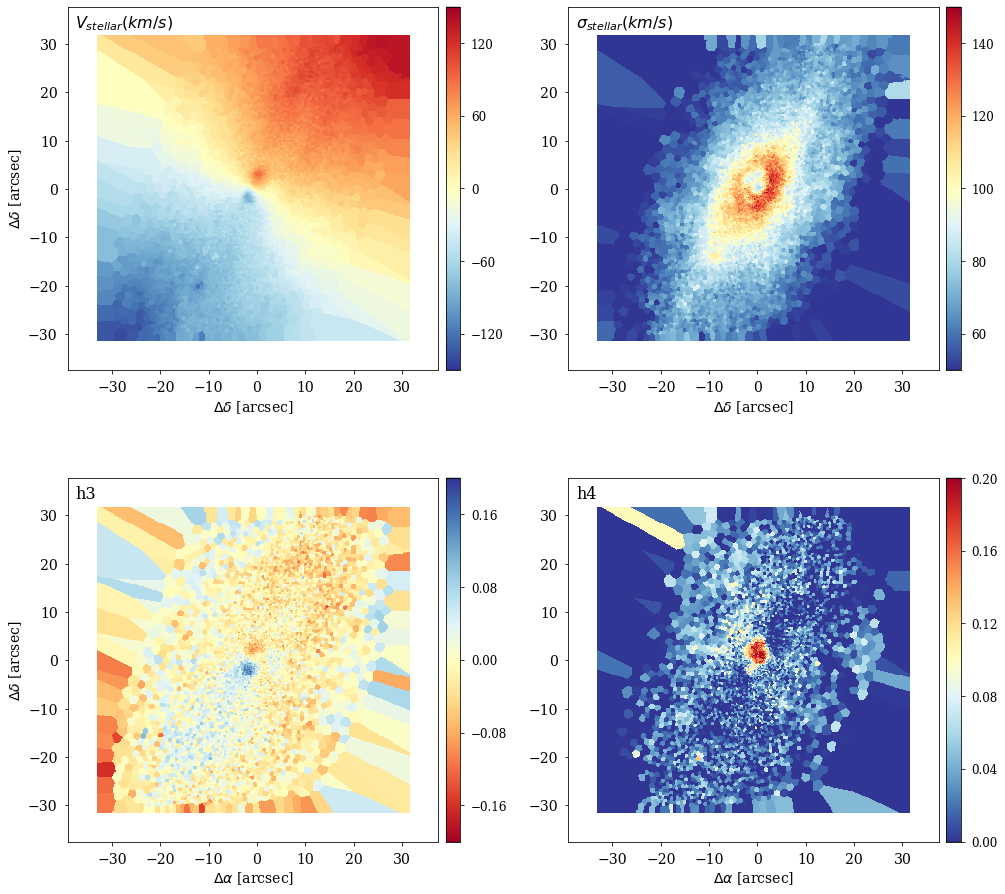

In [93]:
# ppxf example

vminmax=np.zeros((4,2))
vmin_init = [-150, 50, -0.2, 0]   #min value for colorbar for: V, sigma, h3, h4
vmax_init = [150, 150, 0.2, 0.2]  #max value for colorbar for: V, sigma, h3, h4
vminmax[:,0] = vmin_init
vminmax[:,1] = vmax_init

test.plot_PPXF(outdir,vminmax)

In [422]:
vminmax_diff=np.zeros((4,2))
vmin_init_diff = [-100, 0, 0, 0]   
vmax_init_diff = [100, 150, 10, 1000]#max value for colorbar for: V, sigma, flux, amplitude
vminmax_diff[:,0] = vmin_init_diff
vminmax_diff[:,1] = vmax_init_diff

test.StarGasDifference(outdir, 17, vminmax=vminmax_diff, plottype="V", AoNThreshold=4, LEVEL="BIN", title="Ha-Star (core)", AoNToggle = True)
test.StarGasDifference(outdir, 32, vminmax=vminmax_diff, plottype="V", AoNThreshold=4, LEVEL="BIN", title="Ha-Star (blue)", AoNToggle = True)
test.StarGasDifference(outdir, 38, vminmax=vminmax_diff, plottype="V", AoNThreshold=4, LEVEL="BIN", title="Ha-Star (red)", AoNToggle = True)

linelist grabbed


TypeError: Gandalf_setup_plot() missing 1 required positional argument: 'wings'

In [421]:
test.StarGasDifference(outdir,22,vminmax=vminmax_diff,plottype="V",AoNThreshold=-4,LEVEL="BIN",title="Na-Star",AoNToggle=True)
test.StarGasDifference(outdir,23,vminmax=vminmax_diff,plottype="V",AoNThreshold=-4,LEVEL="BIN",title="Na-Star",AoNToggle=True)

NameError: name 'vminmax_diff' is not defined

In [420]:
O3 = [12, 27, 37]
title = ["OIII-Star Core", "OIII-Star blue", "OIII-Star red"]
for i in range(3):
    test.StarGasDifference(outdir, O3[i], vminmax=vminmax_diff, plottype="V", AoNThreshold=4, LEVEL="BIN", title=title[i], AoNToggle = True)

NameError: name 'vminmax_diff' is not defined

In [419]:
N2 = [18, 33, 39]
N2_Title = ["NII-Star core", "NII-Star blue", "NII-Star red"]
for i in range(3):
    test.StarGasDifference(outdir, N2[i], vminmax=vminmax_diff, plottype="V", AoNThreshold=4, LEVEL="BIN", title=N2_Title[i], AoNToggle = True)


NameError: name 'vminmax_diff' is not defined

line 22 selected
linelist grabbed
AoN threshold determined: 0
operation selected: NONE
vmin, vmax set: -100.0 100.0
22
whoops! All NaNs!


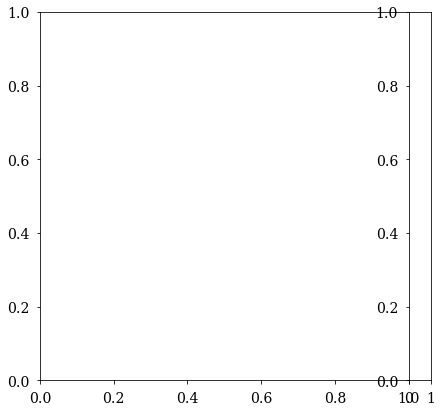

In [426]:
test.Gandalf_gistPlot(outdir,0,22,"V",vminmax=vminmax_gandalf,AoN_Threshold=0,title="Na Disp")